In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings;
warnings.filterwarnings('ignore');

### Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("result/01_date_preprocessing_result.csv",sep=",")
df.head()

### Splitting Data

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

### Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, GlobalMaxPool1D, Dense, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def build_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS,  EMBEDDING_DIM, input_shape=(X_train.shape[1],)))

    model.add(SimpleRNN(32, return_sequences=True, dropout=0.4, recurrent_dropout=0)) 
    model.add(SimpleRNN(16, dropout=0.1, return_sequences=False))
    # model.add(GlobalMaxPooling1D())
    model.add(Dense(5,activation='softmax'))  
   
    return model

In [ ]:
model = build_model()
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
num_epochs = 20
batch_size = 256

## For early stopping to ensure it doesnt overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

407/407 ━━━━━━━━━━━━━━━━━━━━ 116s 286ms/step - accuracy: 0.6977 - loss: 0.7727 - val_accuracy: 0.7643 - val_loss: 0.6819
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 109s 268ms/step - accuracy: 0.7774 - loss: 0.6155 - val_accuracy: 0.7856 - val_loss: 0.6145
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 123s 303ms/step - accuracy: 0.8114 - loss: 0.5400 - val_accuracy: 0.7938 - val_loss: 0.5879
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 131s 322ms/step - accuracy: 0.8306 - loss: 0.4897 - val_accuracy: 0.8069 - val_loss: 0.5875
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 131s 321ms/step - accuracy: 0.8503 - loss: 0.4454 - val_accuracy: 0.8138 - val_loss: 0.5639
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 127s 312ms/step - accuracy: 0.8669 - loss: 0.4094 - val_accuracy: 0.8108 - val_loss: 0.5793
Epoch 8/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 128s 315ms/step - accuracy: 0.8778 - loss: 0.3760 - val_accuracy: 0.8353 - val_loss: 0.5301
Epoch 9/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 136s 335ms/step - accuracy: 0.8901 - loss: 0.34

In [13]:
# Ambil loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

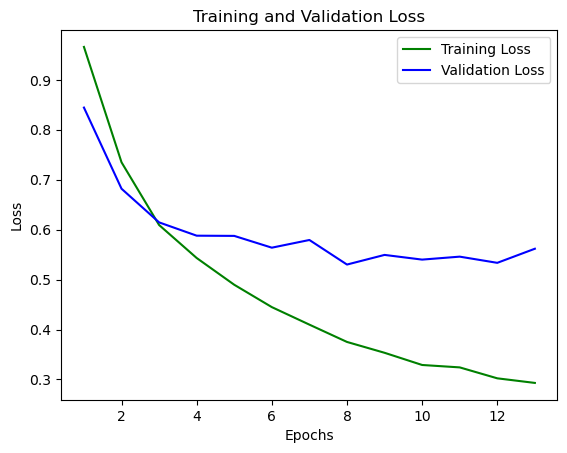

In [14]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Mengevaluasi kinerja model menggunakan data validasi
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Model Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8401 - loss: 0.5163
Model Validation Accuracy: 0.8352574706077576


### Evaluating the Model

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8361 - loss: 0.5263
Test loss: 0.5275802612304688
Test accuracy: 0.8354523777961731
